# Inner approximation: verify whether a given behavior $\vec{p}$ is in $\mathcal{Q}_d$

## Method 1: seesaw algorithm with quadratic programming



A quantum behavior satisfies $\vec{p} = (p_1, p_2, ..., p_n)\in\mathcal{Q}_d$ if and only if the solution of the following optimization is zero.

(Eq. 1)
$$\begin{align}
\min_{X, Y}\quad & \|X - Y\|_F\\
\mathrm{s.t.}\quad & X = X^\dagger, ~ \mathrm{diag}(X) = 1,\\
& X_{0i} = X_{i0} = \sqrt{p_i},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& Y\ge 0, ~ \mathrm{rank}(Y) = d.
\end{align}
$$

This can be solved by alternatingly performing the following two optimization problems

(Eq. 2)
$$\begin{align}
\min_{X}\quad & \|X - Y_\star\|_F\\
\mathrm{s.t.}\quad & X = X^\dagger, ~ \mathrm{diag}(X) = 1,\\
& X_{0i} = X_{i0} = \sqrt{p_i},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E.
\end{align}
$$

(Eq. 3)
$$\begin{align}
\min_{Y}\quad & \|X_\star - Y\|_F\\
\mathrm{s.t.}\quad & Y\ge 0, ~ \mathrm{rank}(Y) = d.
\end{align}
$$

In [1]:
import numpy as np
import cvxpy as cvx
import networkx as nx
import scipy.linalg as lin
from scipy.stats import unitary_group, ortho_group

/tmp/ipykernel_19796/811224743.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.adjacency_matrix(graph, dtype=float).todense()


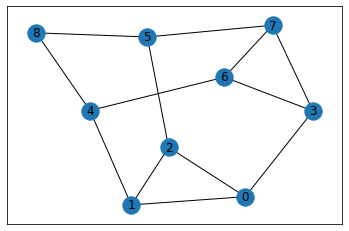

In [2]:
# Define the graph (in graph6 format)
graph = nx.from_graph6_bytes(b'H{O_okK')

# draw the graph
nx.draw_networkx(graph)


# G is the adjacency matrix
G = nx.adjacency_matrix(graph, dtype=float).todense()
#print("The adjacency matrix:\n", G)


# n is the number of vertices
n = G.shape[0]
#print("Number of vertices:", n)

In [3]:
# edge indexing
GE = np.zeros((n+1, n+1))
GE[1:, 1:] = G
GE = GE.astype(bool)

# diag indexing
DD = np.identity(n+1).astype(bool)

In [4]:
# explicit solution to (Eq. 2)

def altQP(Y, p):

    Y[GE] = 0
    Y[DD] = 1
    Y[0, 1:] = np.sqrt(p)
    Y[1:, 0] = np.sqrt(p)
    
    return Y

In [5]:
# explicit solution to (Eq. 3)

def altRank(X, d):
    v, U = lin.eigh(X)
    v[v < 0] = 0
    v[0:n+1-d] = 0
        
    return U @ np.diag(v) @ U.conj().T

In [6]:
# Implement the seesaw algorithm

# Inputs:
# p is the behavior to test
# d is the dimension to test
# num is the number of different initial P_\star to try (default = 5)
# tol is the tolerance for convergence testing  (default = 1e-12)

# Output: the minial ||X - Y|| found



def verify(p, d, num=5, tol=1e-12):

    # initial the minimum of ||X -Y || to be infinity
    xm = np.inf
    
    for i in range(num):

        U = unitary_group.rvs(n+1)
        D = np.zeros(n+1)
        D[n+1-d:] = np.random.randn(d)
        Y = U @ np.diag(np.abs(D)) @ U.conj().T

        val = np.inf
        err = np.inf

        while err > tol:

            X = altQP(Y, p)
            Y = altRank(X, d)

            err = val - lin.norm(X - Y)
            val = lin.norm(X - Y)
        #print(val, err)
        if val < xm:
            xm = val
            
    return xm

In [7]:
p1 = np.array([1/3,1/3,1/3,1/3,1/3,1/3,1/3,1/3,1/3])
p2 = np.array([1/2,1/4,1/4,1/2,0,0,1/4,1/4,1])
p3 = np.array([5/12,7/24,7/24,5/12,1/6,1/6,7/24,7/24,2/3])

print("p3 = (p1 + p2) / 2 ?", np.allclose(p3, (p1 + p2) / 2))

p3 = (p1 + p2) / 2 ? True


In [8]:
print(verify(p=p1, d=3))
print(verify(p=p2, d=3))
print(verify(p=p3, d=3))

1.6988239906290257e-10
7.997446067473254e-11
0.03770130255456643


In [9]:
p4 = np.array([1/3,1/3,1/3,0,2/3,1/3,0,0,1/3])

In [10]:
print(verify(p=p4, d=4))

0.003159722327753625
